In [5]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# # Pytorch Gpu Configuration for Cuda
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
import torch_directml

device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [56]:
# Data import
# transform = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize([.5,.5,.5], [.5,.5,.5])])
trainSet = tv.datasets.CIFAR10(root="../Datasets/", train=True, download=True)
devSet = tv.datasets.CIFAR10(root="../Datasets/", train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [57]:
# Classes
classes = trainSet.classes

# Training Data pre processing
train_data = copy.deepcopy(trainSet.data)
train_data = train_data.reshape(50000, 3, 32, 32)
train_data = np.array(train_data)
train_labels = np.array(trainSet.targets)

# Dev Data Pre_processing
dev_data = copy.deepcopy(devSet.data)
dev_data = dev_data.reshape(10000, 3, 32, 32)
dev_data = np.array(dev_data)
dev_labels = np.array(devSet.targets).reshape((len(devSet.targets), 1))

##### Data Normalization #####
dev_data = dev_data / np.max(dev_data)
train_data = train_data / np.max(train_data)

# Convert data and label to tensors
train_data = torch.tensor(train_data).float()
train_labels = torch.tensor(train_labels).long()
dev_data = torch.tensor(dev_data).float()
dev_labels = torch.tensor(dev_labels).long()

# Dev / Test split
dev_data, test_data, dev_labels, test_labels = train_test_split(
    dev_data, dev_labels, test_size=0.5
)

#convert into PyTorch Datasets
dev_data = TensorDataset(dev_data, dev_labels)
test_data = TensorDataset(test_data, test_labels)
train_data = TensorDataset(train_data, train_labels)

# Data loader objects
batchSize=32
train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True, drop_last=True, generator=torch.Generator(device=device))
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0], generator=torch.Generator(device=device))
dev_loader = DataLoader(dev_data, batch_size=dev_data.tensors[0].shape[0], generator=torch.Generator(device=device))


tensor([1, 7, 3, 5, 4, 1, 7, 4, 3, 9, 1, 1, 0, 8, 9, 2, 6, 8, 0, 7, 6, 9, 1, 2,
        9, 6, 9, 9, 8, 5, 3, 3], device='privateuseone:0')


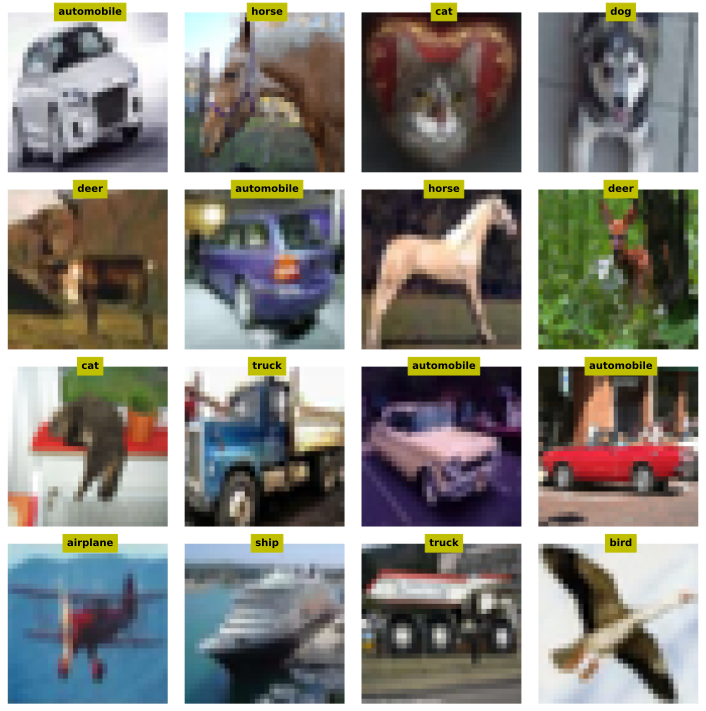

In [59]:
#inspect a few random images
X, y = next(iter(train_loader))
print(y)
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].cpu().reshape(32, 32, 3)
    # and its label
    label = classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(
        16, 0, label, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

In [60]:
# Create a function to create a model
# Basic knowledge
# Image size = 32X32
# Output class predictions = 10
def createCIFAR10Net(print_toggle=False):
    class cifar10Net(nn.Module):

        def __init__(self, print_toggle):
            super().__init__()
            self.print = print_toggle

            # Convolution layers
            self.conv1 = nn.Conv2d(3, 128, 3, padding=1) 
            self.bnorm1 = nn.BatchNorm2d(128)
            # Output => (32 + 2*1 - 3 / 1 + 1 / 2) => 16
            self.conv2 = nn.Conv2d(128, 256, 3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(256)
            # Output => (16 + 2*1 - 3 / 1 + 1 / 2) => 8
            self.conv3 = nn.Conv2d(256, 512, 3)
            self.bnorm3 = nn.BatchNorm2d(512)
            # Output => (8 + 2*1 - 3 / 1 + 1 / 2) => 4

            # Fully Connected Layers
            self.fc1 = nn.Linear(3*3*512, 512)
            self.fc2 = nn.Linear(512, 128)
            self.fc3 = nn.Linear(128, 10)

        def forward(self, x):
            if self.print:
                print(f"Input: {list(x.shape)}")

            # Conv 1
            x = self.conv1(x)
            x = F.max_pool2d(x, 2)
            x = self.bnorm1(x)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f'Conv1 Output: {list(x.shape)}')
            # Conv 2
            x = self.conv2(x)
            x = F.max_pool2d(x, 2)
            x = self.bnorm2(x)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f'Conv2 Output: {list(x.shape)}')

            # Conv 3
            x = self.conv3(x)
            x = F.max_pool2d(x, 2)
            x = self.bnorm3(x)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f'Conv3 Output: {list(x.shape)}')

            # Reshape for the Linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print:
                print(f'Vectorized: {list(x.shape)}')

            # Linear Layers

            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = self.fc3(x)
            if self.print:
                print(f'Final output: {list(x.shape)}')
            return x

    # Model instance
    net = cifar10Net(print_toggle)

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossFun, optimizer

In [61]:
# Test with some data
net, lossFun, optimizer = createCIFAR10Net(True)

# Some data
X, y = next(iter(train_loader))
print(X.shape, y.shape)
yHat = net(X)
# Check the output size
print(f"Output size: {yHat.shape}\n")

# Loss Function
loss = lossFun(yHat, torch.squeeze(y))
print(f"Loss: {loss}")

torch.Size([32, 3, 32, 32]) torch.Size([32])
Input: [32, 3, 32, 32]
Conv1 Output: [32, 128, 16, 16]
Conv2 Output: [32, 256, 8, 8]
Conv3 Output: [32, 512, 3, 3]
Vectorized: [32, 4608]
Final output: [32, 10]
Output size: torch.Size([32, 10])

Loss: 2.2915921211242676


In [62]:
# Function to train the model
def functionToTrainTheModel(epochs=10, print_toggle=False):
    # Model Instance
    net, lossFun, optimizer = createCIFAR10Net(print_toggle)

    # Loss and Errorrate
    trainLosses = torch.zeros(epochs)
    devLosses = torch.zeros(epochs)
    trainErrors = torch.zeros(epochs)
    devErrors = torch.zeros(epochs)

    # The Loop
    for epoch in range(epochs):
        print(f"Started on  Epoch: {epoch+1} / {epochs}")
        net.train()

        # Batch error and loss
        batchErr = []
        batchLoss = []

        for X, y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, torch.squeeze(y))

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss and error rate
            batchLoss.append(loss.cpu().item())
            batchErr.append(
                torch.mean((torch.argmax(yHat, axis=1) != y).float()).cpu().item()
            )
            # End of batch
        # Training Loss and error
        trainLosses[epoch] = np.mean(batchLoss)
        trainErrors[epoch] = 100 * np.mean(batchErr)

        # Dev Performance
        net.eval()
        X,y = next(iter(dev_loader))
        with torch.no_grad():
            yHat = net(X)
            loss = lossFun(yHat, torch.squeeze(y))
        devLosses[epoch] = loss.cpu().item()
        devErrors[epoch] = (
            100 * torch.mean((torch.argmax(yHat, axis=1) != y).float()).cpu().item()
        )
        # End of epoch
        print(f"Completed Epoch: {epoch+1} / {epochs}")

    return trainLosses, devLosses, trainErrors, devErrors, net

In [ ]:
# Test the model
trainLosses, devLosses, trainErrors, devErrors, net = functionToTrainTheModel(epochs=5, print_toggle=False)

Started on  Epoch: 1 / 5


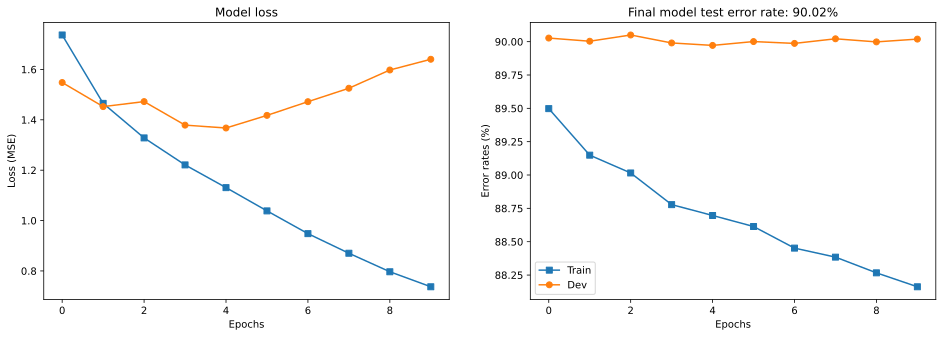

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLosses.cpu().detach(), "s-", label="Train")
ax[0].plot(devLosses.cpu().detach(), "o-", label="Dev")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss (MSE)")
ax[0].set_title("Model loss")

ax[1].plot(trainErrors.cpu().detach(), "s-", label="Train")
ax[1].plot(devErrors.cpu().detach(), "o-", label="Dev")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error rates (%)")
ax[1].set_title(
    f"Final model test error rate: {devErrors[-1].cpu().detach():.2f}%"
)
ax[1].legend()

plt.show()